In [1]:
from llmfact import LayerOutputExtractor, FBNFeatureExtractor, GroupFBNFeatureExtractor, FBNExtractor, LLMFC
from llmfact.extractor import MutiLayerAnalysis
from llmfact.extractor import SingleLayerAnalysis
from llmfact.mask import MaskedGPT2ForSequenceClassification, MaskedGPT2AmplifiedForSequenceClassification, MaskedGPT2LMModel, MaskedModel
from transformers import GPT2Model, GPT2Config, GPT2LMHeadModel, GPT2ForSequenceClassification, Trainer, TrainingArguments
from transformers import GPT2Tokenizer
from transformers import AutoTokenizer, AutoModel, AutoConfig, AutoModelForCausalLM, AutoModelForQuestionAnswering
from datasets import load_dataset, get_dataset_config_names, get_dataset_split_names
from torch.utils.data import DataLoader
# from rouge_score import rouge_scorer
from evaluate import load

from llmfact.utils import IoU, correlation_activation, thresholding, write_layer_txt, evaluate_iou
from llmfact.stat import  StatICA, StatDictionaryLearning
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.decomposition import FastICA
import seaborn as sns
import pandas as pd
from tqdm.auto import tqdm
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '4'
os.environ["TOKENIZERS_PARALLELISM"]  = "true"

In [2]:
def plot(selected_token, threshold=10, binary=False):
    abs_selected_token = np.abs(selected_token) 
    
    abs_selected_token[abs_selected_token > threshold] = threshold

    if binary:
        abs_selected_token[abs_selected_token < threshold] = 0
    
    plt.figure(figsize=(10,  8))
     
    # 绘制热力图，使用亮度表示绝对值大小 
    cmap = plt.cm.get_cmap('PuRd')   # 使用 'viridis' 色带，可以根据需要选择其他色带
    im = plt.imshow(abs_selected_token,  aspect='auto', cmap=cmap)
     
    # 添加白色的分隔线
    for i in range(1, abs_selected_token.shape[0]): 
        plt.axhline(y=i  - 0.5, color='white', linewidth=0.5)  # 在每一层之间添加白色线条
     
    # 添加 colorbar
    cbar = plt.colorbar(im) 
    cbar.set_label('Absolute  Value Magnitude')
     
    # 设置坐标轴标签
    plt.xlabel('Feature  Index')
    plt.ylabel('Layer  Index')
    plt.title('Visualization of Selected Token with Absolute Value Brightness')
     
    # 显示图像
    plt.tight_layout() 
    plt.show() 

In [3]:
from scipy.stats  import pearsonr, spearmanr
from statsmodels.tsa.stattools  import ccf
def resample_v(v1, v2):
    # if save_se:
    #     start_v1 = v1[0]
    #     end_v1 = v1[-1]
    #     start_v2 = v2[0]
    #     end_v2 = v2[-1]
        
    # if remove:
    #     v1 = v1[1:-1]
    #     v2 = v2[1:-1]
        
    v1_len = len(v1)
    v2_len = len(v2)

    if v1_len > v2_len:
        v_len = v2_len
        indices = torch.linspace(0,  v_len - 1, v_len).int()  # 计算采样索引 
        v1 = v1[indices]
    elif v1_len < v2_len:
        v_len = v1_len
        indices = torch.linspace(0,  v_len - 1, v_len).int()  # 计算采样索引 
        v2 = v2[indices]

    # if save_se:
    #     v1[0] = start_v1
    #     v1[-1] = end_v1
    #     v2[0] = start_v2
    #     v2[-1] = end_v2
        
    return v1, v2

def compute_pcc(v1, v2):
    v1, v2 = resample_v(v1, v2)

    # pcc, p_value = pearsonr(v1, v2)
    pcc, p_value = spearmanr(v1, v2)
    # pcc, p_value = spearmanr(v1, v2)
    # print(f"PCC:{pcc}, P Value:{p_value:.4f}")
    return pcc, p_value

# compute_pcc(avg_values[1:-2], avg_values2[1:-2])

In [4]:
from tqdm import trange
from llmfact.decomposition.canica import CanICA
from llmfact.utils import z_score_signals
def compute_mask(layer_outputs_list, n_components=20):
    layer_outputs = torch.cat(layer_outputs_list, dim=0)
    layer_outputs = z_score_signals(layer_outputs).to(torch.float64)
    canica = CanICA(n_components=n_components,
                     random_state=666,
                     device="cuda")
    canica.fit(layer_outputs)
    normal_components = canica.normal_mixing_
    components = torch.abs(normal_components) > 3.6
    return components

def get_mask_index(mask_model):
    mask_indices_list = []
    for i in range(mask_model.shape[0]):
        mask = mask_model[i]
        mask_indices = np.where(mask == True)[0]
        mask_indices_list.append(mask_indices)
    return mask_indices_list
    
def compute_all_fbn(layer_outputs_list_1, layer_outputs_list_2, n_components=20):
    if isinstance(layer_outputs_list_1, str):
        layer_outputs_list_1 = torch.load(layer_outputs_list_1)

    if isinstance(layer_outputs_list_2, str):
        layer_outputs_list_2 = torch.load(layer_outputs_list_2)

    components_1 = compute_mask(layer_outputs_list_1, n_components=n_components).detach().cpu()
    components_2 = compute_mask(layer_outputs_list_2, n_components=n_components).detach().cpu()

    mask_indices_1 = get_mask_index(components_1)
    mask_indices_2 = get_mask_index(components_2)
    pcc_list = []
    for i in trange(10):
        features_1 = layer_outputs_list_1[i]
        features_2 = layer_outputs_list_2[i]

        pcc_ls = []
        
        for j in range(n_components):
            selected_feature_1 = features_1[:, mask_indices_1[j]]
            v1 = torch.mean(selected_feature_1, dim=1)

            for k in range(n_components):
                selected_feature_2 = features_2[:, mask_indices_2[k]]
                v2 = torch.mean(selected_feature_2, dim=1)
                # print(f"{i}:{j}:{k}:", end=" ")
                pcc, p = compute_pcc(v1, v2)
                pcc_ls.append(pcc)
        pcc_list.append(pcc_ls)
    return pcc_list

In [5]:
def compute_matrix(pcc_list, n_components=64, threshold=0.5):
    pcc_list = np.concatenate([pcc.reshape(1, -1) for pcc in pcc_list], axis=0)
    mean_matrix = np.mean(pcc_list, axis=0).reshape(n_components, n_components)
    pcc_list = pcc_list.reshape(-1, n_components, n_components)
    index = np.argwhere(mean_matrix > threshold)
    print((mean_matrix > threshold).sum())
    for i in index:
        print(i, mean_matrix[i[0],i[1]])
        for j in range(pcc_list.shape[0]):
            print(f"{pcc_list[j][i[0]][i[1]]:.4f}")

In [6]:
class LLMFBNAnalysis:
    def __init__(self, layer_outputs_list_1, layer_outputs_list_2, n_components=20, device='cuda', scaling=None, permutation=False):
        if isinstance(layer_outputs_list_1, str):
            self.layer_outputs_list_1 = torch.load(layer_outputs_list_1)
        else:
            self.layer_outputs_list_1 = layer_outputs_list_1

        if isinstance(layer_outputs_list_2, str):
            self.layer_outputs_list_2 = torch.load(layer_outputs_list_2)
        else:
            self.layer_outputs_list_2 = layer_outputs_list_2

        if scaling:
            self.layer_outputs_list_1 = [self.layer_outputs_list_1[i] * scaling for i in range(len(self.layer_outputs_list_1))]

        if permutation:
            perm = torch.randperm(self.layer_outputs_list_1[0].size(1))
            self.layer_outputs_list_1 = [self.layer_outputs_list_1[i][:, perm] for i in range(len(self.layer_outputs_list_1))]

        self.n_components = n_components
        self.device = device

    def compute_mask(self, layer_outputs_list, n_components=20):
        layer_outputs = torch.cat(layer_outputs_list, dim=0)
        layer_outputs = z_score_signals(layer_outputs).to(torch.float64)
        canica = CanICA(n_components=n_components,
                         random_state=666,
                         device=self.device)
        canica.fit(layer_outputs)
        normal_components = canica.normal_mixing_
        components = torch.abs(normal_components) > 3.6
        return components

    def get_mask_index(self, mask_model):
        mask_indices_list = []
        for i in range(mask_model.shape[0]):
            mask = mask_model[i]
            mask_indices = np.where(mask == True)[0]
            mask_indices_list.append(mask_indices)
        return mask_indices_list

    def fit(self):
        self.components_1 = self.compute_mask(self.layer_outputs_list_1, n_components=self.n_components).detach().cpu()
        self.components_2 = self.compute_mask(self.layer_outputs_list_2, n_components=self.n_components).detach().cpu()
    
        self.mask_indices_1 = self.get_mask_index(self.components_1)
        self.mask_indices_2 = self.get_mask_index(self.components_2)
        self.pcc_list = []

        sample_num = len(self.layer_outputs_list_1)
        for i in trange(sample_num):
            features_1 = self.layer_outputs_list_1[i]
            features_2 = self.layer_outputs_list_2[i]
    
            pcc_ls = []
            
            for j in range(self.n_components):
                selected_feature_1 = features_1[:, self.mask_indices_1[j]]
                v1 = torch.mean(selected_feature_1, dim=1)
    
                for k in range(self.n_components):
                    selected_feature_2 = features_2[:, self.mask_indices_2[k]]
                    v2 = torch.mean(selected_feature_2, dim=1)
                    pcc, p = compute_pcc(v1, v2)
                    pcc_ls.append(pcc)
            self.pcc_list.append(pcc_ls)
        self.pcc_list = np.array(self.pcc_list).reshape(sample_num, self.n_components, self.n_components)

    def predict(self, layer_outputs_1, layer_outputs_2):
        self.pcc_list = []
        if isinstance(layer_outputs_1, str):
            layer_outputs_1 = torch.load(layer_outputs_1)

        if isinstance(layer_outputs_2, str):
            layer_outputs_2 = torch.load(layer_outputs_2)
            
        sample_num = len(layer_outputs_1)
        for i in trange(sample_num):
            features_1 = layer_outputs_1[i]
            features_2 = layer_outputs_2[i]

            pcc_ls = []

            for j in range(self.n_components):
                selected_feature_1 = features_1[:, self.mask_indices_1[j]]
                v1 = torch.mean(selected_feature_1, dim=1)
    
                for k in range(self.n_components):
                    selected_feature_2 = features_2[:, self.mask_indices_2[k]]
                    v2 = torch.mean(selected_feature_2, dim=1)
                    pcc, p = compute_pcc(v1, v2)
                    pcc_ls.append(pcc)
            self.pcc_list.append(pcc_ls)
        self.pcc_list = np.array(self.pcc_list).reshape(sample_num, self.n_components, self.n_components)

    def predict_mask(self, layer_outputs_1, layer_outputs_2, index_1=None, index_2=None, verbose=True):
        if isinstance(layer_outputs_1, str):
            layer_outputs_1 = torch.load(layer_outputs_1)

        if isinstance(layer_outputs_2, str):
            layer_outputs_2 = torch.load(layer_outputs_2)

        pcc_ls = []
        
        sample_num = len(layer_outputs_1)
        for i in trange(sample_num):
            features_1 = layer_outputs_1[i]
            features_2 = layer_outputs_2[i]
            
            if index_1 is not None:
                selected_feature_1 = features_1[:, self.mask_indices_1[index_1]]
                v1 = torch.mean(selected_feature_1, dim=1)
            elif index_2 is not None:
                selected_feature_1 = features_1[:, self.mask_indices_2[index_2]]
                v1 = torch.mean(selected_feature_1, dim=1)
            else:
                ValueError("Must have index 1 or index 2")

            if index_2 is not None:
                selected_feature_2 = features_2[:, self.mask_indices_2[index_2]]
                v2 = torch.mean(selected_feature_2, dim=1)
            elif index_1 is not None:
                selected_feature_2 = features_2[:, self.mask_indices_1[index_1]]
                v2 = torch.mean(selected_feature_2, dim=1)
            else:
                ValueError("Must have index 1 or index 2")

            pcc, p = compute_pcc(v1, v2)
            
            pcc_ls.append(pcc)
        pcc_list = np.array(pcc_ls)

        if verbose:
            print("Mean PCC:", np.mean(pcc_list))
            for pcc in pcc_list:
                print(pcc)
        return pcc_list

    def selected_features_plot(self, index_1, index_2, resample=False):
        for i in range(len(self.layer_outputs_list_1)):
            features_1 = self.layer_outputs_list_1[i]
            features_2 = self.layer_outputs_list_2[i]
    
            selected_features_1 = features_1[:, self.mask_indices_1[index_1]]
            selected_features_2 = features_2[:, self.mask_indices_2[index_2]]
    
            v1 = torch.mean(selected_features_1, dim=1)
            v2 = torch.mean(selected_features_2, dim=1)

            if resample:
                v1, v2 = resample_v(v1, v2)
    
            fig, ax1 = plt.subplots() 
            ax2 = ax1.twinx()
            ax1.plot(v1,  'g-', label='V 1')
            ax2.plot(v2,  'b-', label='V 2')
             
            ax1.set_xlabel('Index') 
            ax1.set_ylabel('Vector 1', color='g')
            ax2.set_ylabel('Vector 2', color='b')
            plt.title("Dual Y-axis Comparison")
            plt.show() 

In [7]:
analysis = LLMFBNAnalysis("./data/llemma-7b-wikitext2-10-4096.pth", "./data/llama2-7b-chat-hf-wikitext2-10-4096", n_components=64, permutation=True)
analysis.fit()

100%|██████████| 10/10 [01:49<00:00, 10.99s/it]


In [12]:
compute_matrix(analysis.pcc_list, n_components=64, threshold=0.5)

10
[ 2 14] 0.5588054879452613
0.5948
0.5352
0.6692
0.5918
0.5279
0.5535
0.5047
0.5035
0.5067
0.6006
[20 37] 0.5341756613283242
0.5588
0.6733
0.5642
0.5374
0.5068
0.5337
0.4543
0.4787
0.4726
0.5619
[28 32] 0.61722576412235
0.5854
0.6906
0.5198
0.6845
0.6235
0.6642
0.5299
0.5286
0.6126
0.7332
[31 28] 0.7221236449401512
0.6798
0.6280
0.6587
0.7655
0.7687
0.7801
0.7680
0.6651
0.7094
0.7979
[37 54] 0.5853240771015897
0.4992
0.5577
0.5333
0.5559
0.6280
0.6493
0.5952
0.6123
0.6091
0.6131
[38 45] 0.697031353578968
0.7682
0.6683
0.7841
0.7103
0.5930
0.6302
0.6966
0.6627
0.7128
0.7442
[51  5] 0.7996871588298731
0.8335
0.8241
0.7972
0.8598
0.7714
0.7725
0.7261
0.7844
0.8137
0.8140
[54 25] 0.5178235371250719
0.4895
0.7073
0.5651
0.4425
0.5289
0.3334
0.4781
0.5345
0.4153
0.6836
[63  1] 0.5462314396327895
0.5397
0.5692
0.6074
0.4308
0.5435
0.6288
0.5826
0.5001
0.4564
0.6039
[63  2] 0.8724471790768279
0.9099
0.8571
0.9049
0.8829
0.8595
0.9117
0.8413
0.8268
0.8715
0.8589


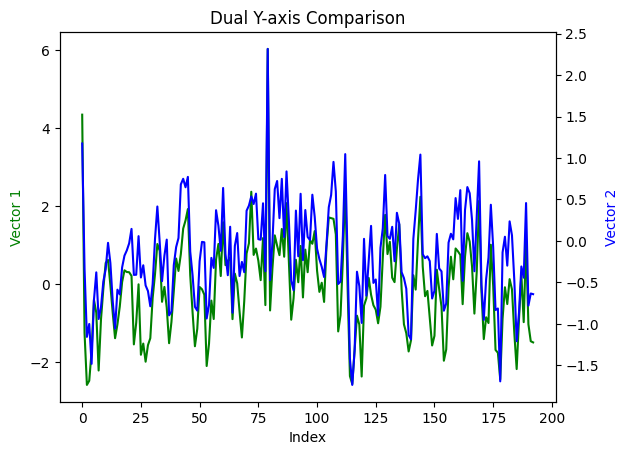

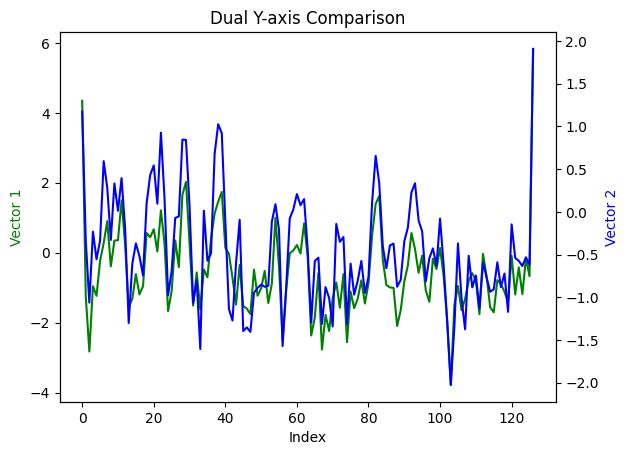

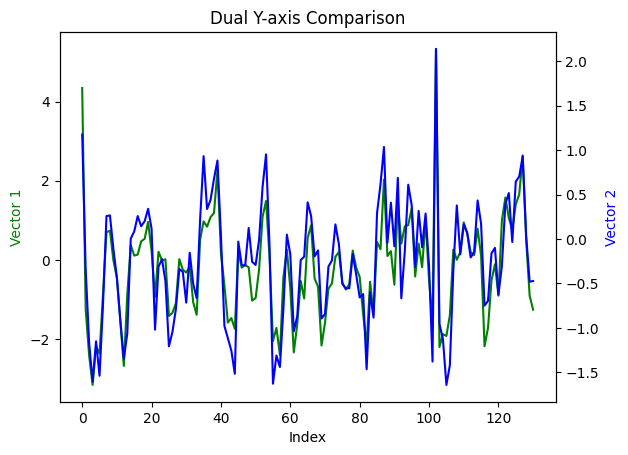

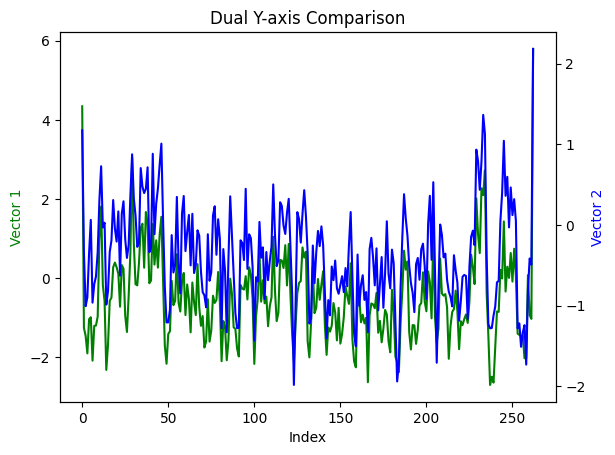

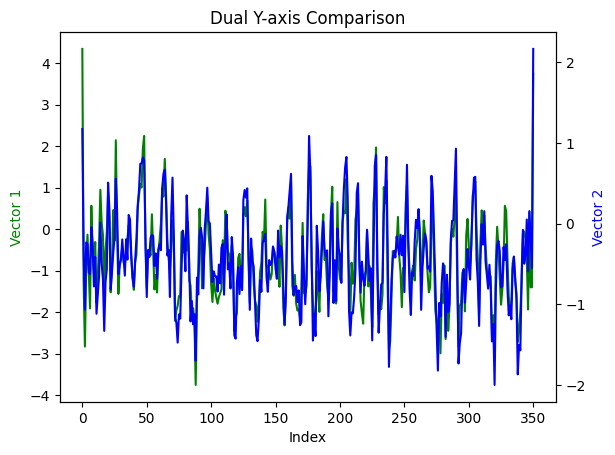

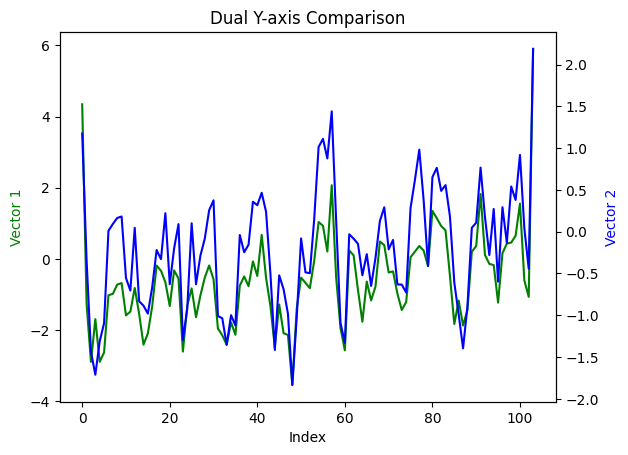

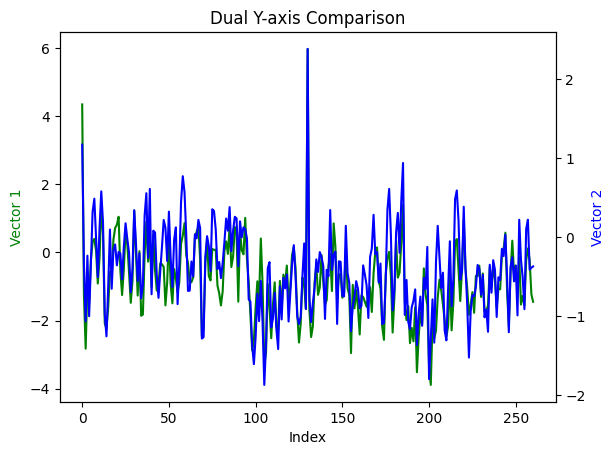

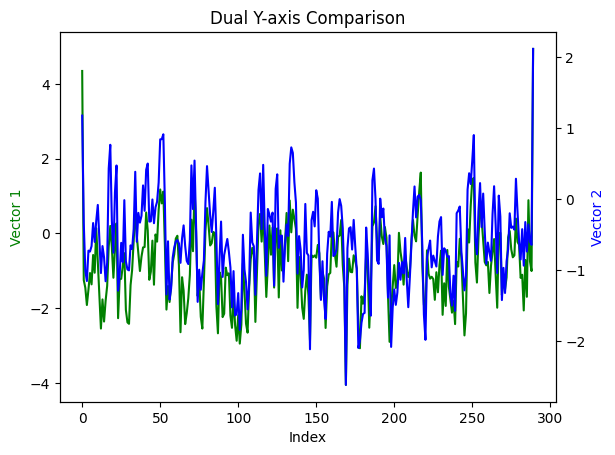

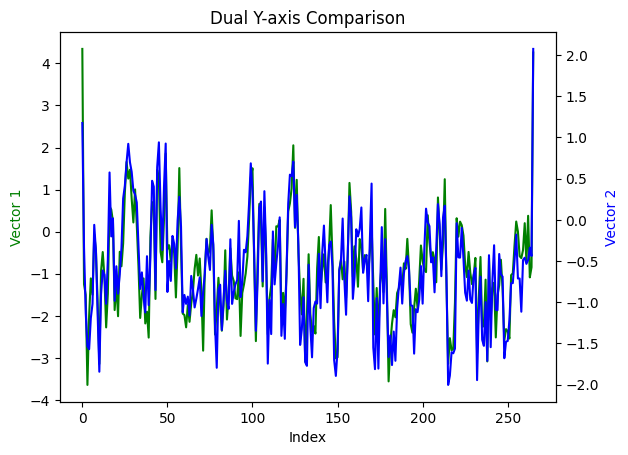

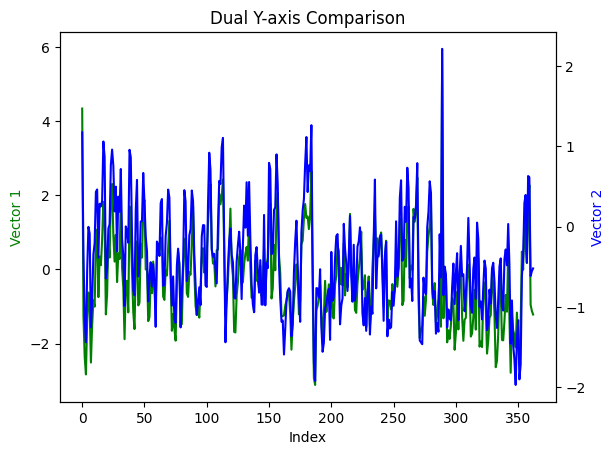

In [13]:
analysis.selected_features_plot(63, 2)

In [20]:
analysis = LLMFBNAnalysis("./data/llama2-7b-chat-hf-wikitext2-10-4096", "./data/vicuna-7b-wikitext2-10-4096.pth", n_components=64)
analysis.fit()

100%|██████████| 10/10 [01:32<00:00,  9.26s/it]


In [8]:
compute_matrix(analysis.pcc_list, n_components=64, threshold=0.5)

2
[ 2 19] 0.521524114397146
0.5428
0.4961
0.5387
0.5408
0.5227
0.5587
0.4343
0.5105
0.4978
0.5727
[28 21] 0.5963385281497449
0.6331
0.6373
0.4612
0.5255
0.6812
0.5571
0.6051
0.6212
0.6468
0.5949
